### Carregando os arquivos:

In [63]:
import pandas as pd

train_df  = pd.read_csv("../data/raw/train.csv")
unique_m_df = pd.read_csv("../data/raw/unique_m.csv")

### Separando em treino - teste:

In [64]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(train_df, test_size=0.2, random_state=42)

train_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)

### Visualizando os 5 primeiros dados:

In [65]:
train_df.loc[:4, ["number_of_elements", "mean_atomic_mass", "mean_fie", "mean_atomic_radius", "mean_Density", "mean_ElectronAffinity", "mean_FusionHeat", "mean_ThermalConductivity", "mean_Valence"]]

number_of_elements  mean_atomic_mass    mean_fie  mean_atomic_radius  \
0                   2         77.143500  730.650000          172.500000   
1                   4        104.365600  891.650000          154.250000   
2                   5         74.231650  816.360000          160.000000   
3                   7         88.309607  726.442857          161.142857   
4                   5         69.321369  860.620000          143.400000   

   mean_Density  mean_ElectronAffinity  mean_FusionHeat  \
0   8265.000000              32.150000        17.700000   
1   6501.357250              69.837500         5.903000   
2   4816.685800              62.090000         8.014400   
3   5180.489857              52.985714         7.041714   
4   5828.485800              71.180000        12.964400   

   mean_ThermalConductivity  mean_Valence  
0                 46.500000      4.000000  
1                106.581645      2.000000  
2                111.005316      2.200000  
3                109.860940      2.571429  
4                 48.405316      3.600000

### Verificando se há dados nulos:

In [66]:
train_df.isnull().sum()

number_of_elements       0
mean_atomic_mass         0
wtd_mean_atomic_mass     0
gmean_atomic_mass        0
wtd_gmean_atomic_mass    0
                        ..
range_Valence            0
wtd_range_Valence        0
std_Valence              0
wtd_std_Valence          0
critical_temp            0
Length: 82, dtype: int64

In [67]:
train_df.isnull().sum().sum()

np.int64(0)

### Verificando se a ordem do arquivo de treino e do arquivo de identificação é compatível

In [68]:
if len(train_df) != len(unique_m_df):
    print(f'Número de linhas difere: train={len(train_df)}, unique={len(unique_m_df)}')
else:
    # Comparando a temperatura crítica e verificando igualdade:
    mismatches = train_df['critical_temp'] != unique_m_df['critical_temp']
    if mismatches.any():
        idx = mismatches[mismatches].index.tolist()
        print(f'Diferenças encontradas em {len(idx)} linhas: {idx}')
    else:
        print('Todas as temperaturas críticas batem.')

Número de linhas difere: train=17010, unique=21263


### Analisando correlação entre as variáveis:

In [69]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

### Visualizando relação entre features e o alvo:

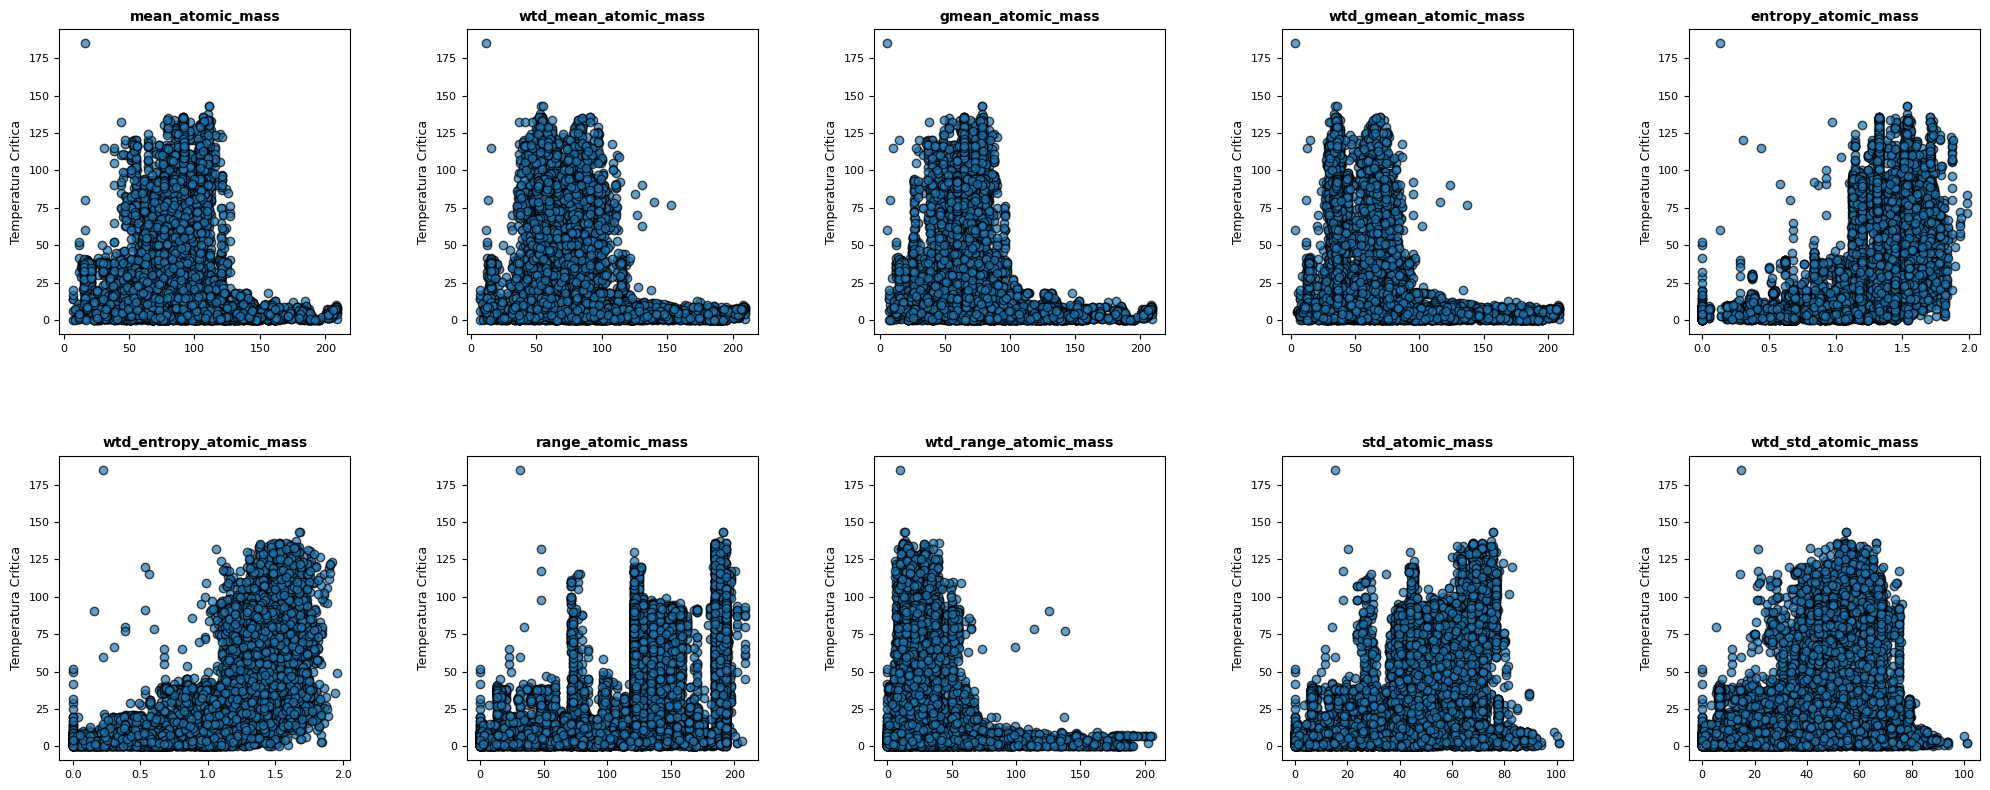

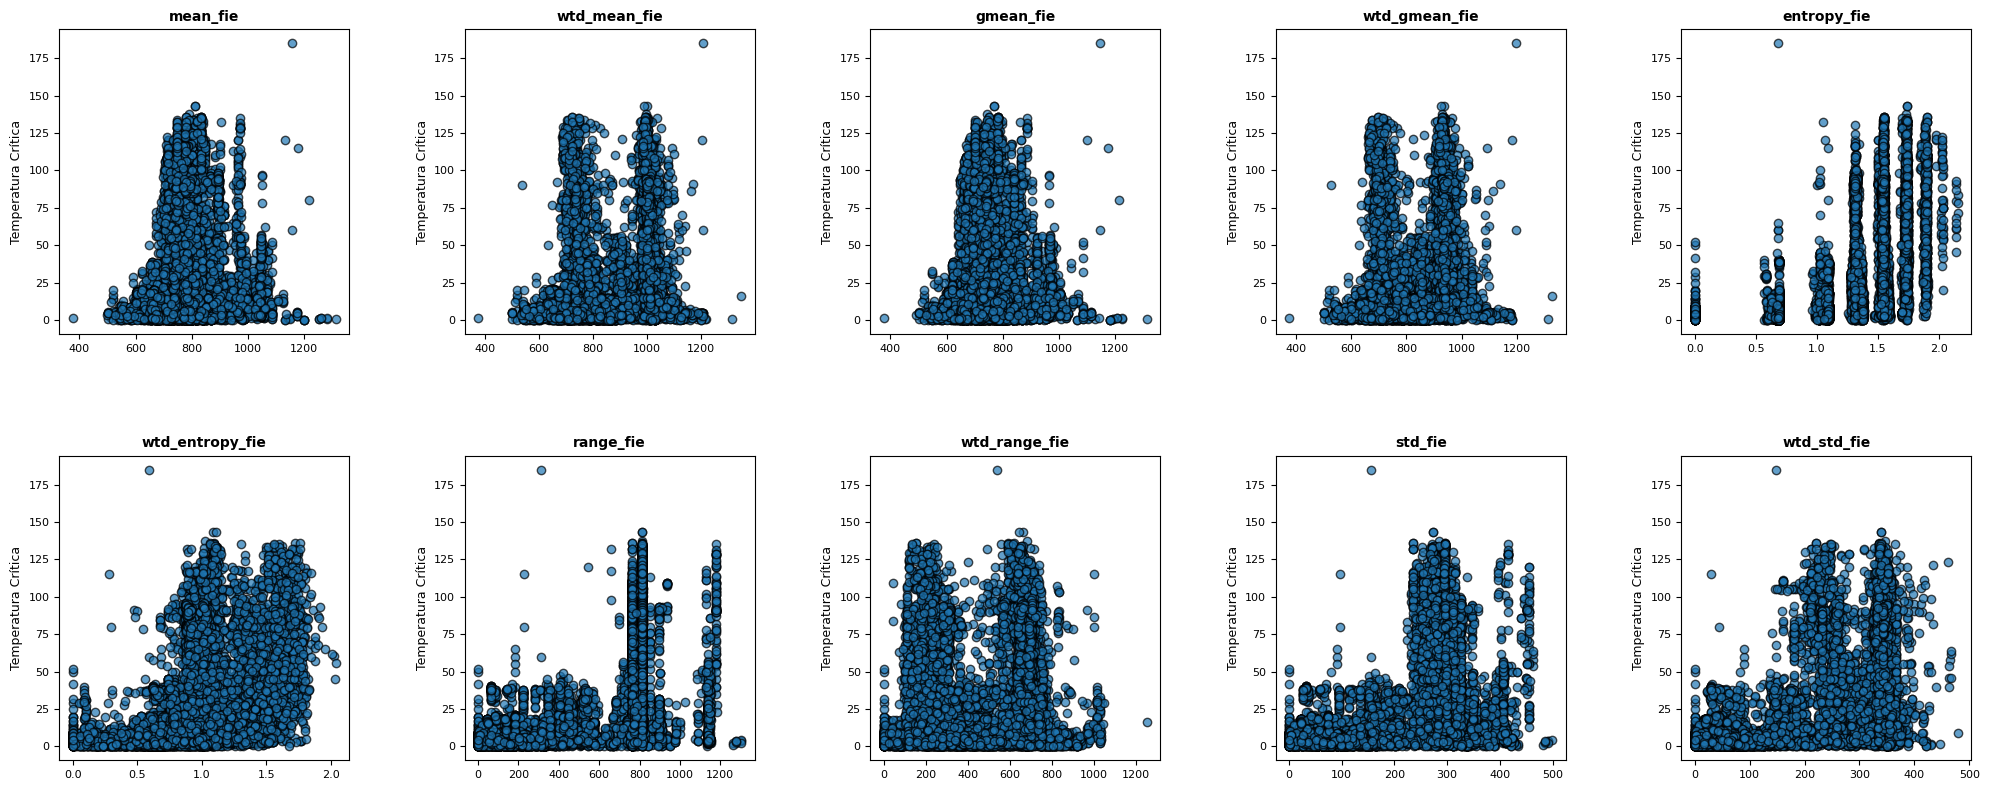

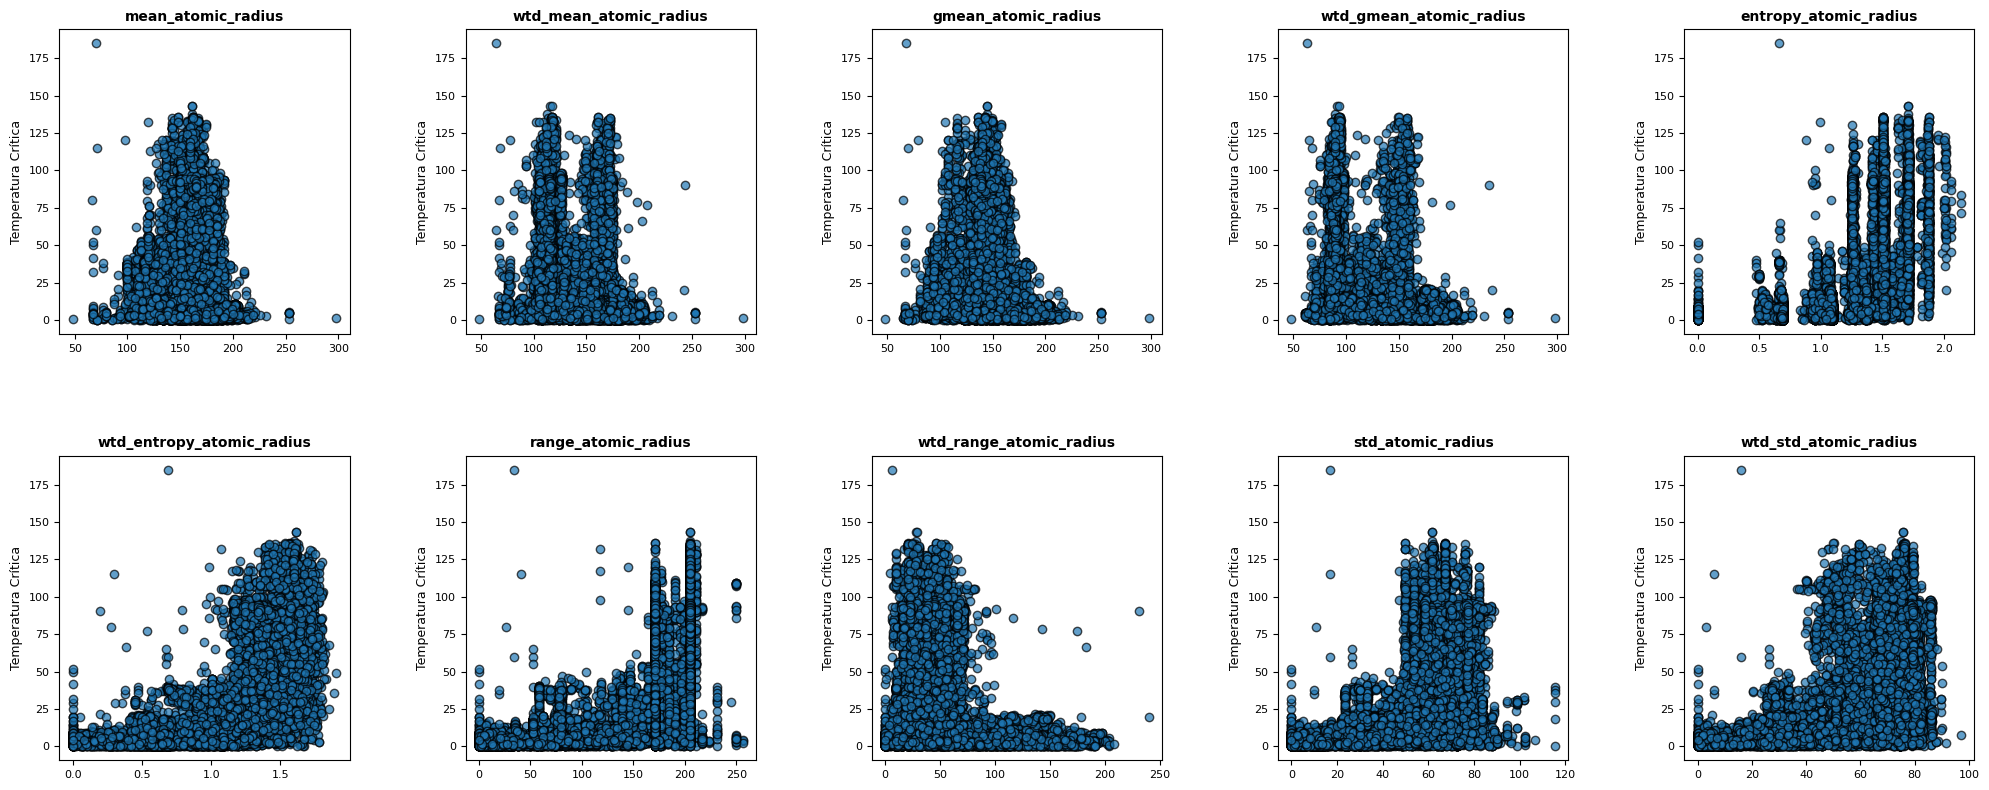

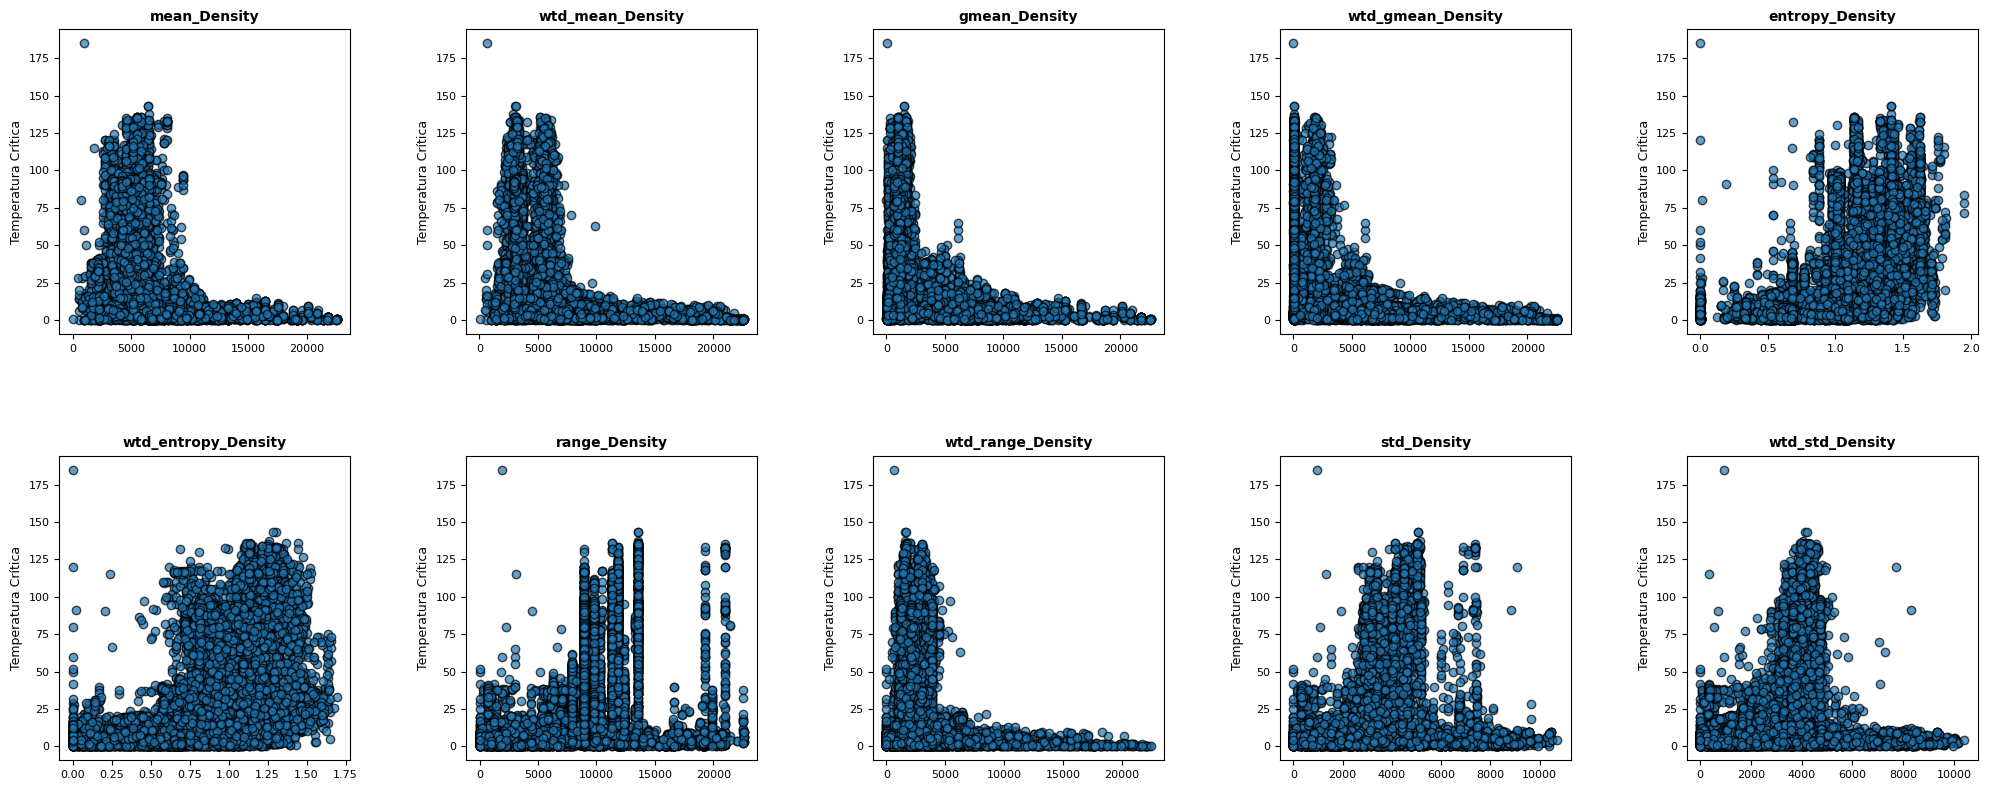

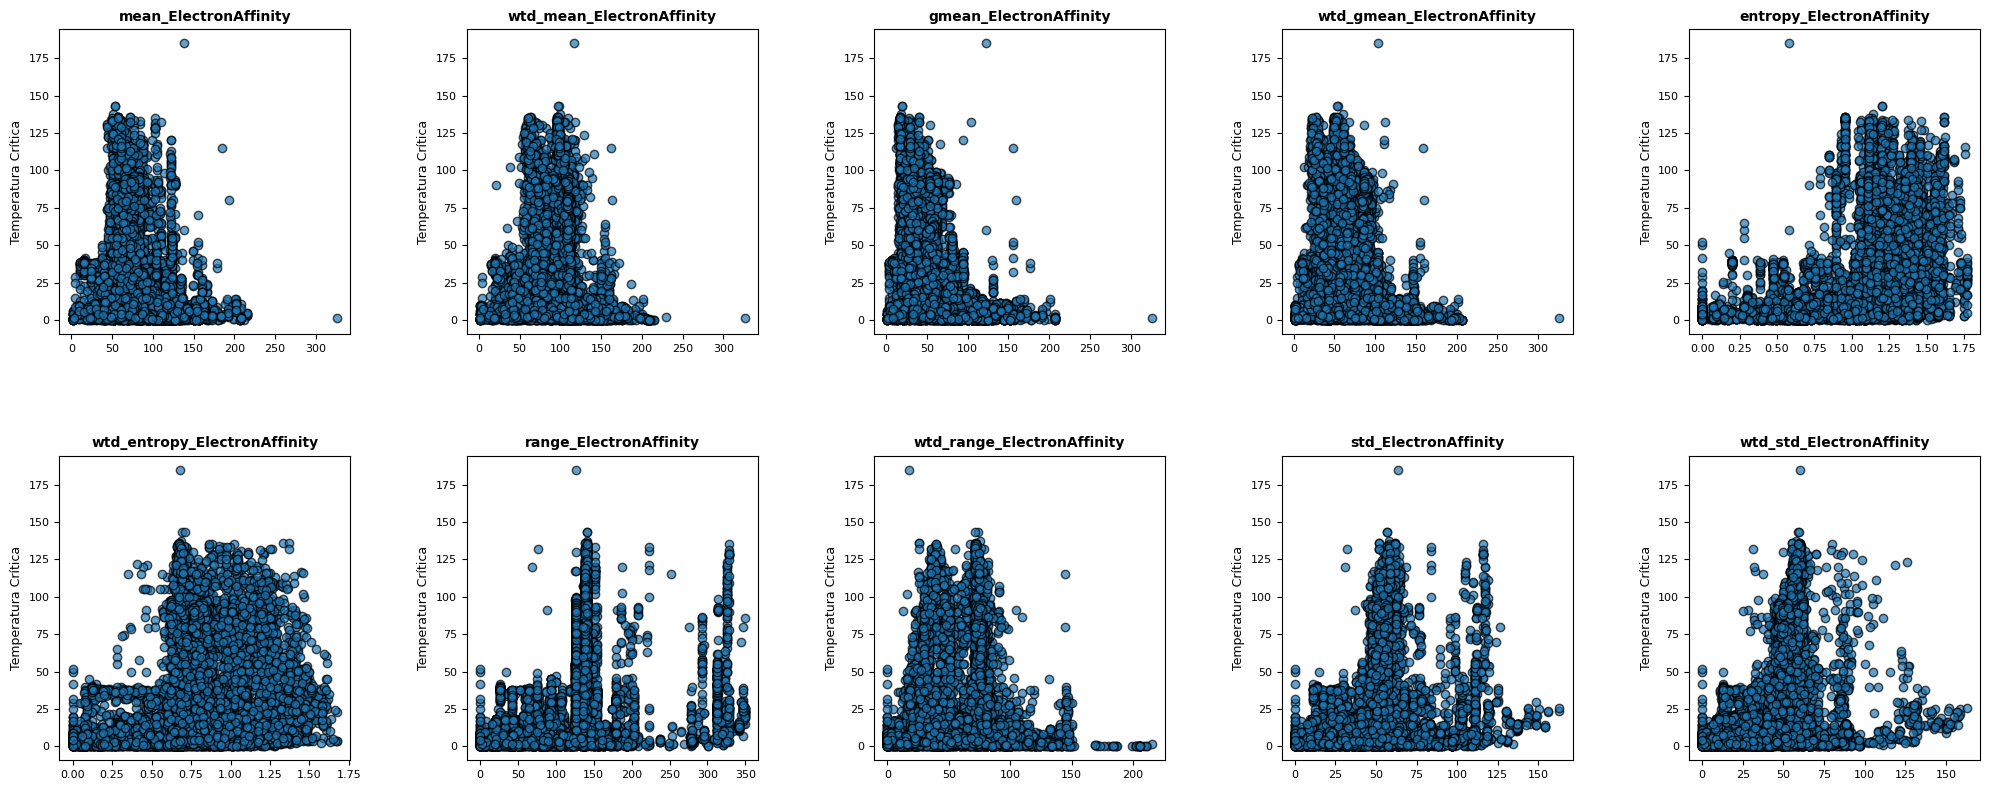

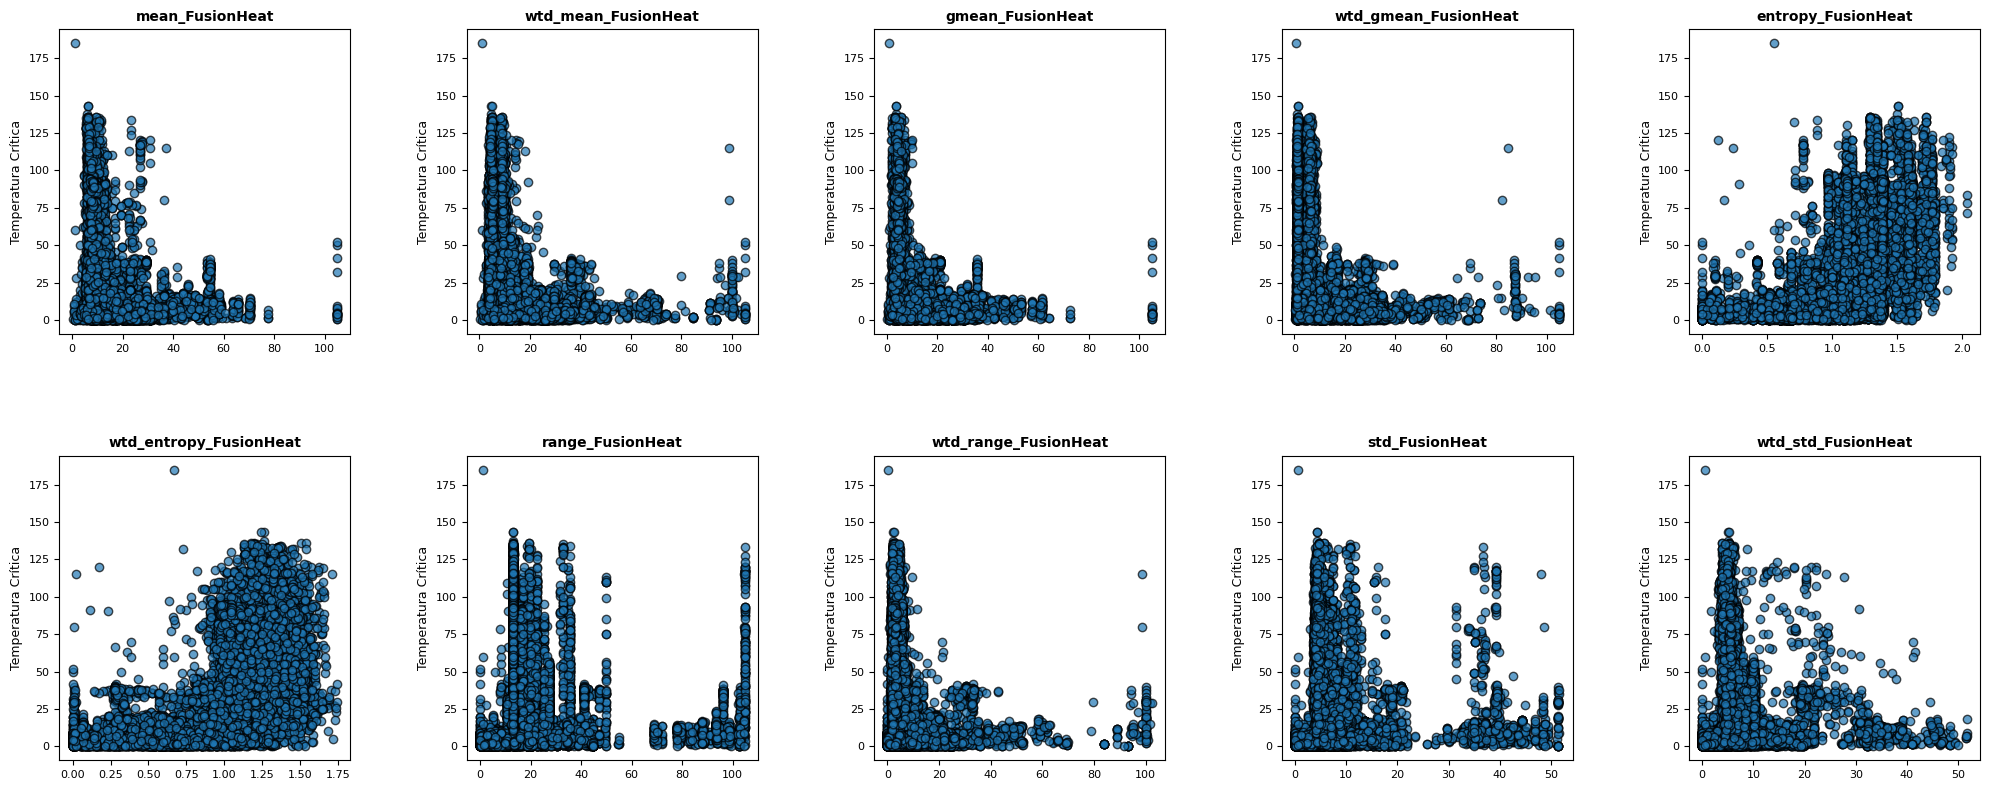

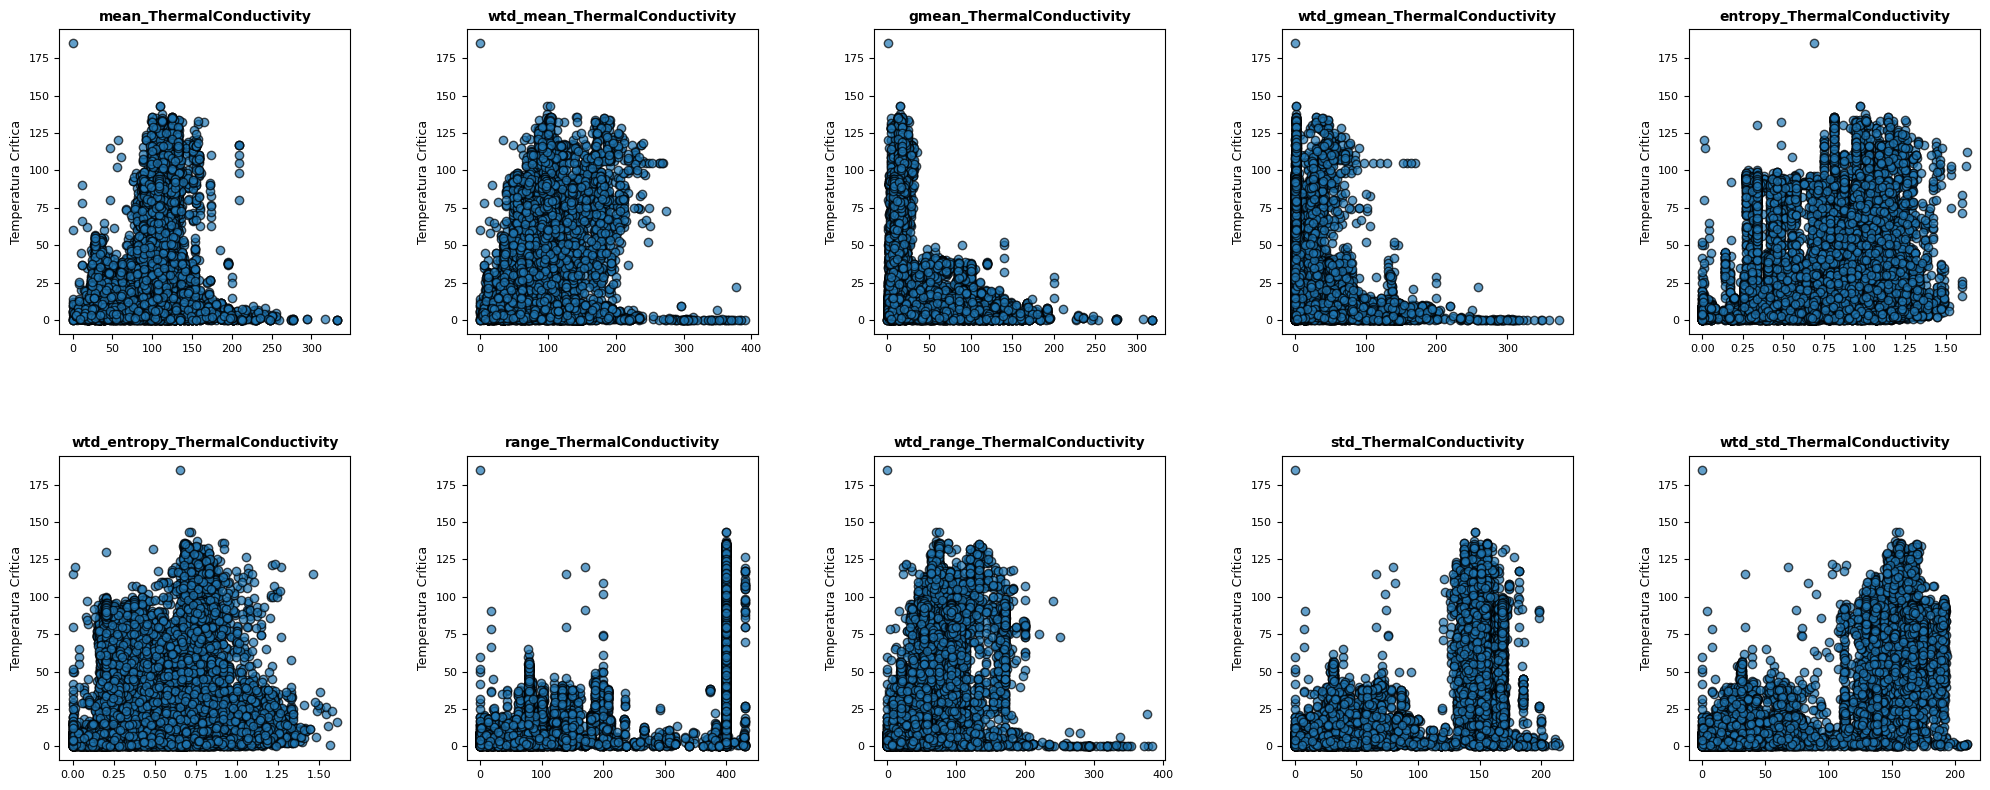

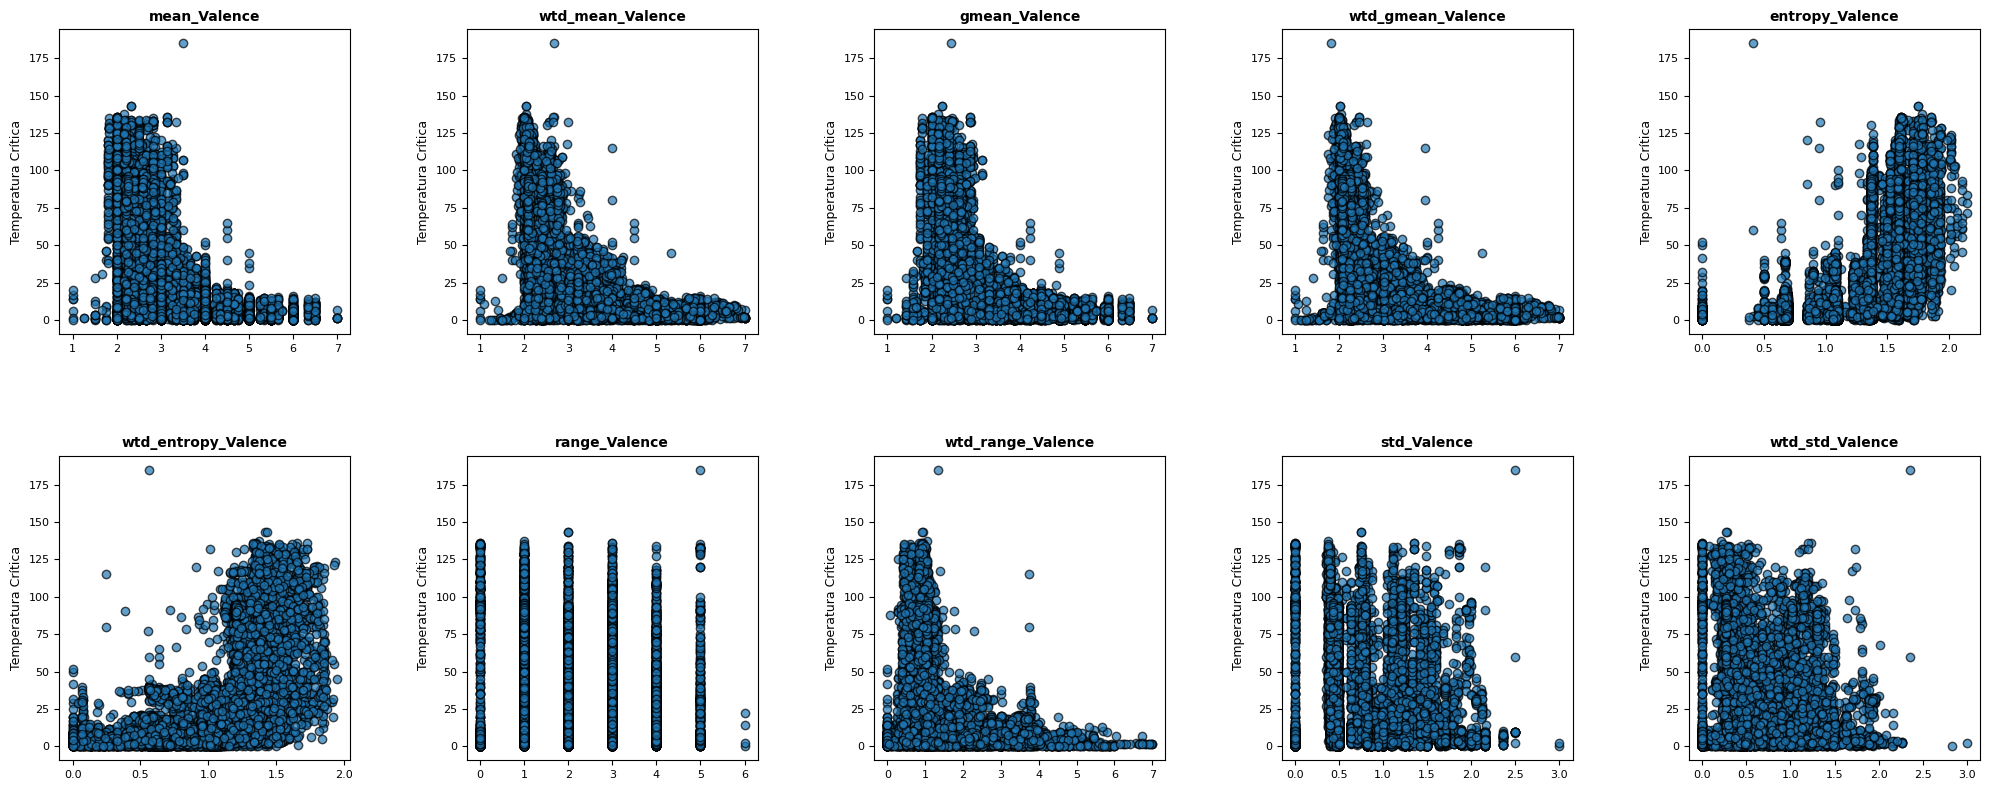

In [70]:
import matplotlib.pyplot as plt

features = list(train_df.columns)
features.remove('critical_temp')  # tirando a coluna alvo

# Dividindo os grupos de 10:
grouped_features = [features[i:i+10] for i in range(1, len(features), 10)]

# Para cada grupo:
for idx, feature_group in enumerate(grouped_features):
    fig, axes = plt.subplots(2, 5, figsize=(20, 8))
    axes = axes.flatten()

    for i, feature in enumerate(feature_group):
        axes[i].scatter(train_df[feature], train_df['critical_temp'], alpha=0.7, edgecolors='k')
        axes[i].set_ylabel('Temperatura Crítica', fontsize=9)
        axes[i].set_title(feature, fontsize=10, fontweight='bold')
        axes[i].tick_params(axis='both', labelsize=8)

    # Retira eixos vazios se sobrar:
    for j in range(len(feature_group), 10):
        fig.delaxes(axes[j])

    # Ajusta layout:
    plt.tight_layout()
    plt.subplots_adjust(wspace=0.4, hspace=0.4)

    # Mostra o grupo:
    plt.show()

### Mapa de Correlação - Mutual Information (comprimido):

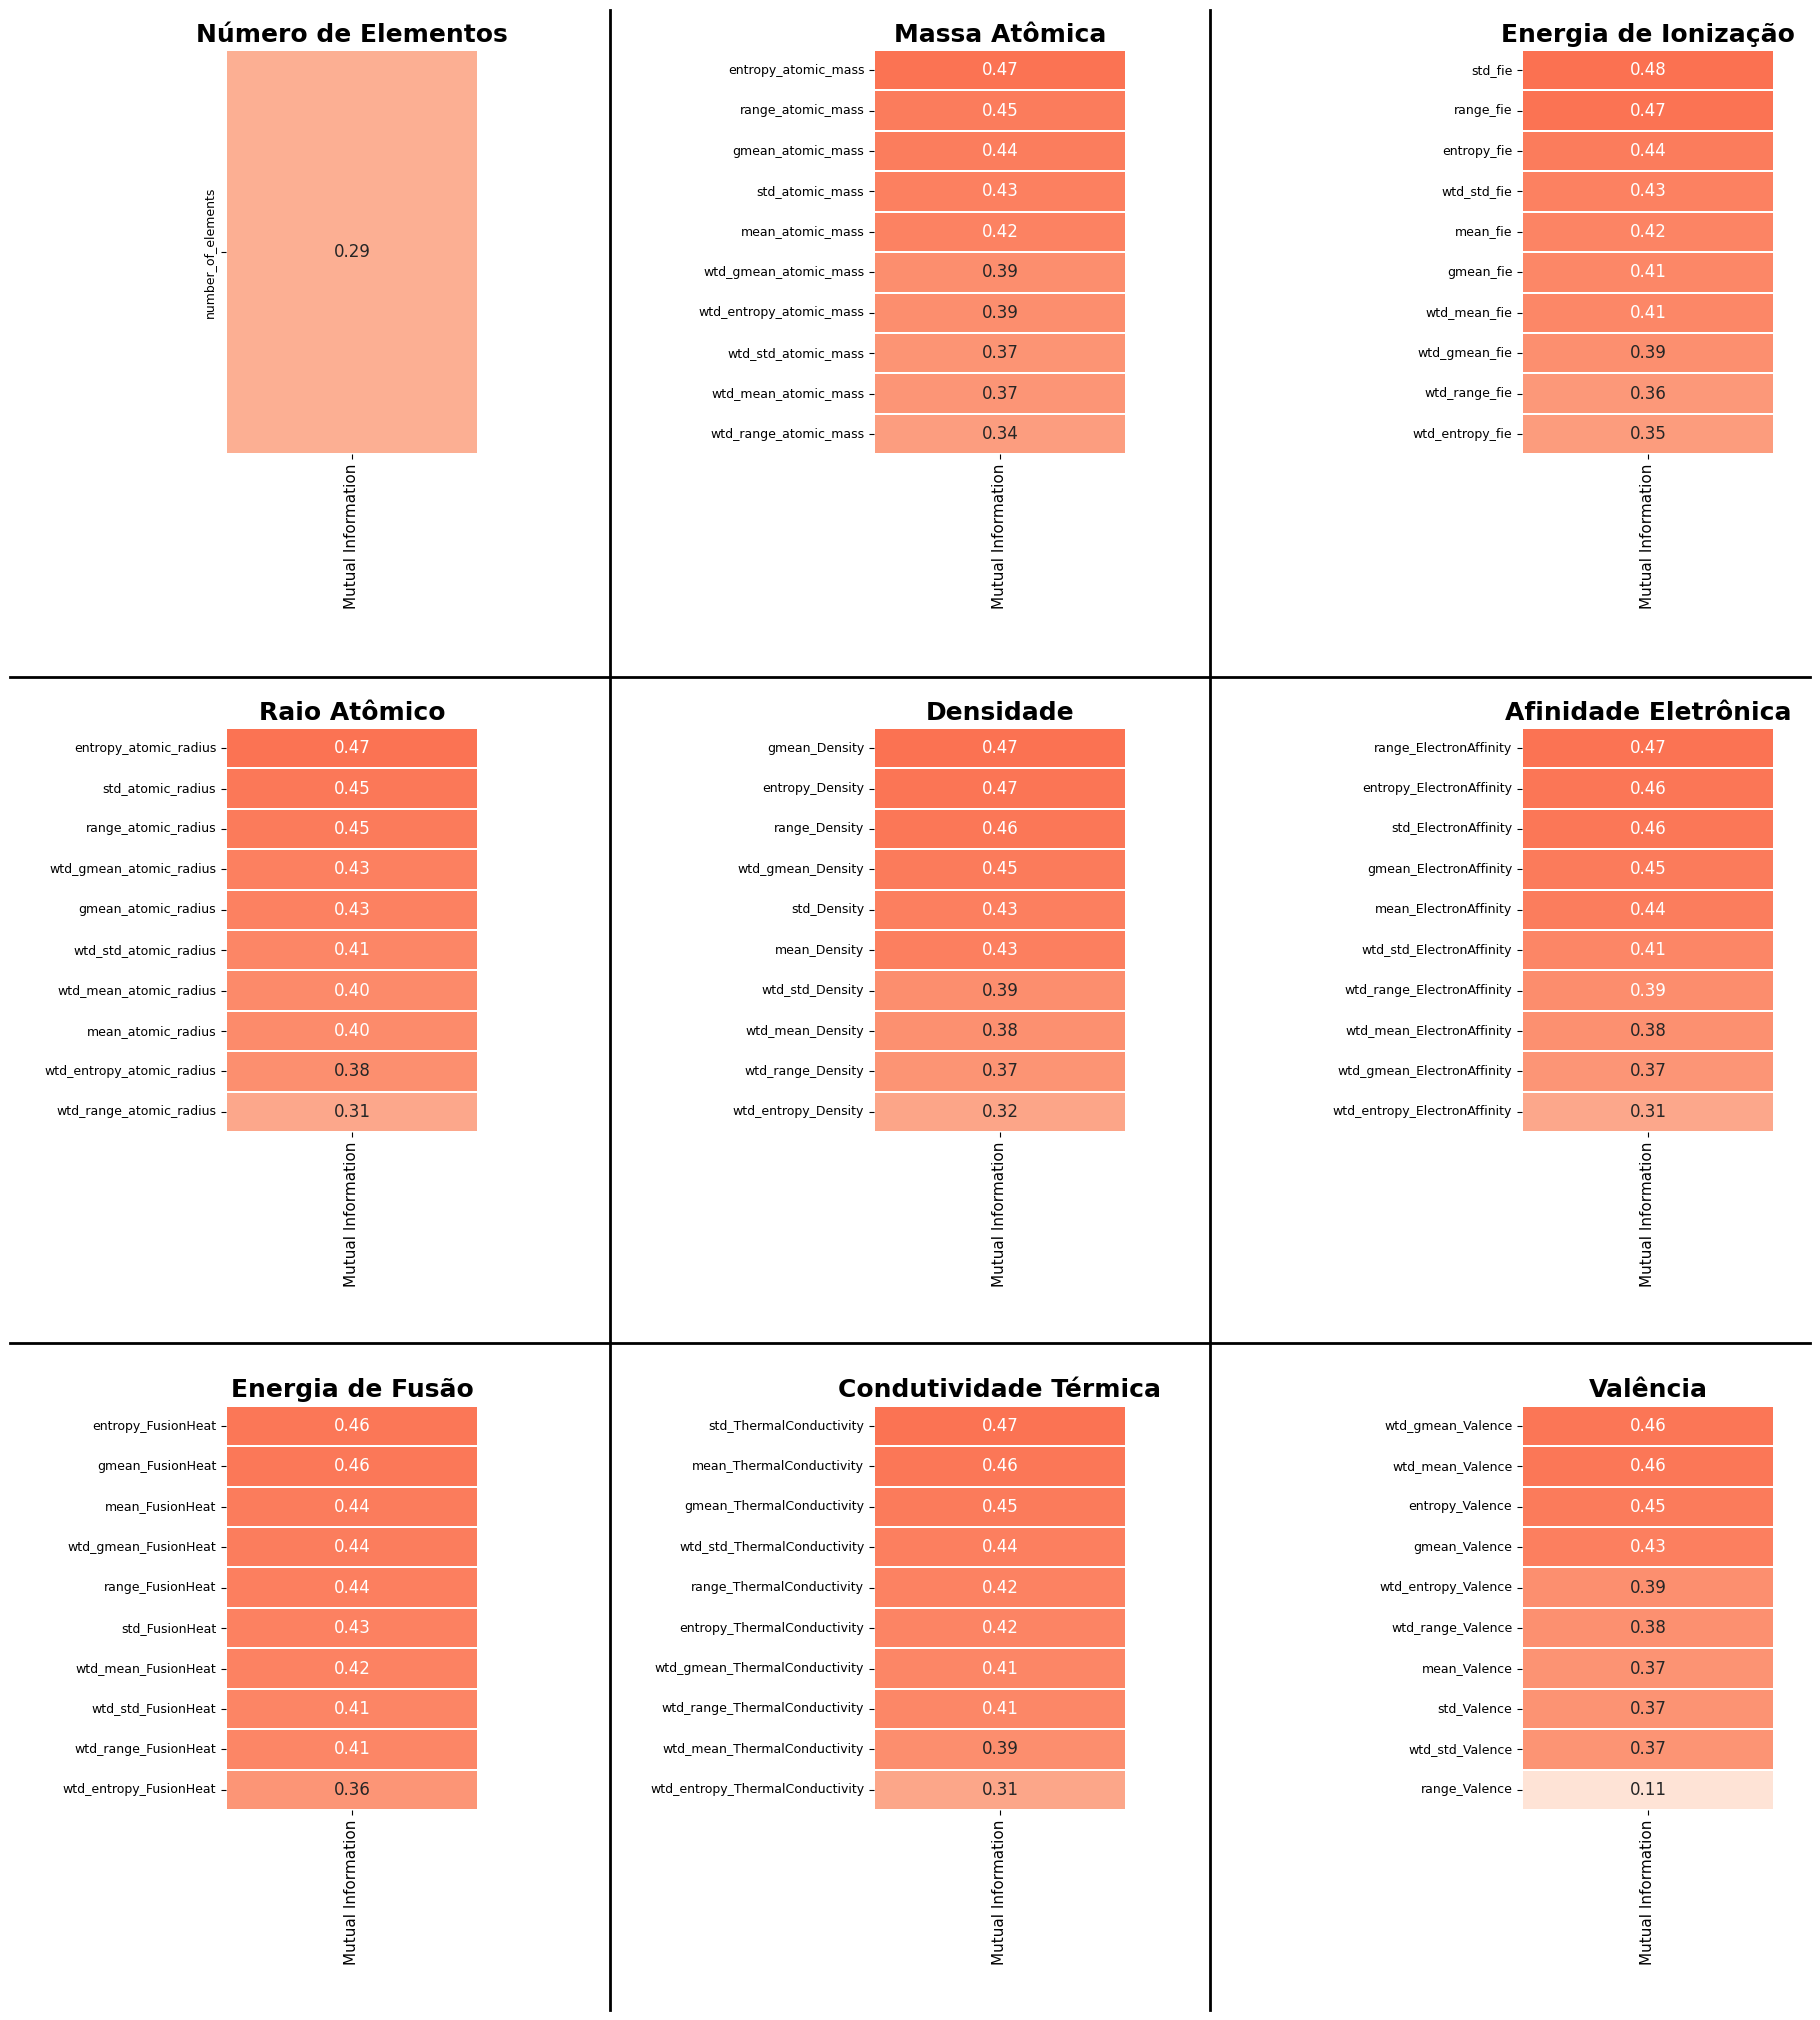

In [73]:
from sklearn.feature_selection import mutual_info_regression
from matplotlib import gridspec, lines

# Configura a figura e o GridSpec:
fig = plt.figure(figsize=(18, 20))
gs = gridspec.GridSpec(
    nrows=3, ncols=3,
    left=0.10, right=1.00, top=1.00, bottom=0.08,
    wspace=1.0, hspace=0.4
)

axes = [fig.add_subplot(gs[i]) for i in range(9)]

for i, ax in enumerate(axes):
    # calcula o mutual information
    mi_values = []
    for feature in feature_groups[i]:
        X = train_df[[feature]].values
        y = train_df['critical_temp'].values
        mi = mutual_info_regression(X, y, random_state=42)
        mi_values.append(mi[0])

    mi_df = pd.DataFrame({'Feature': feature_groups[i], 'Mutual Information': mi_values})
    mi_df.sort_values('Mutual Information', ascending=False, inplace=True)
    mi_df.set_index('Feature', inplace=True)

    # Compressão MI = MI / (1 + MI):
    mi_df_compressed = mi_df / (1 + mi_df)

    # Encurta o axes:
    pos = ax.get_position()
    ax.set_position([
        pos.x0 + 0.02,
        pos.y0 + 0.02,
        pos.width  - 0.04,
        pos.height - 0.04
    ])

    # Plota heatmap compacto (entre 0 e 1):
    sns.heatmap(
        mi_df_compressed,
        annot=True,
        fmt=".2f",
        cmap='Reds',
        center=0.5,
        vmin=0, vmax=1,
        cbar=False,
        linewidths=0.3,
        linecolor='white',
        annot_kws={"size": 12},
        ax=ax
    )
    ax.set_title(group_titles[i], fontsize=18, fontweight='bold')
    ax.set_ylabel('')
    ax.tick_params(axis='x', rotation=90, labelsize=11)
    ax.tick_params(axis='y', labelsize=9)

# Desenha as 4 linhas que formam o grid 3×3 na figura inteira:
for x in [1/3, 2/3]:
    fig.add_artist(lines.Line2D([x, x], [0, 1],
                                transform=fig.transFigure,
                                color='black', linewidth=2))
for y in [1/3, 2/3]:
    fig.add_artist(lines.Line2D([0, 1], [y, y],
                                transform=fig.transFigure,
                                color='black', linewidth=2))

plt.show()

### Gráficos de frequência e BoxPlot:

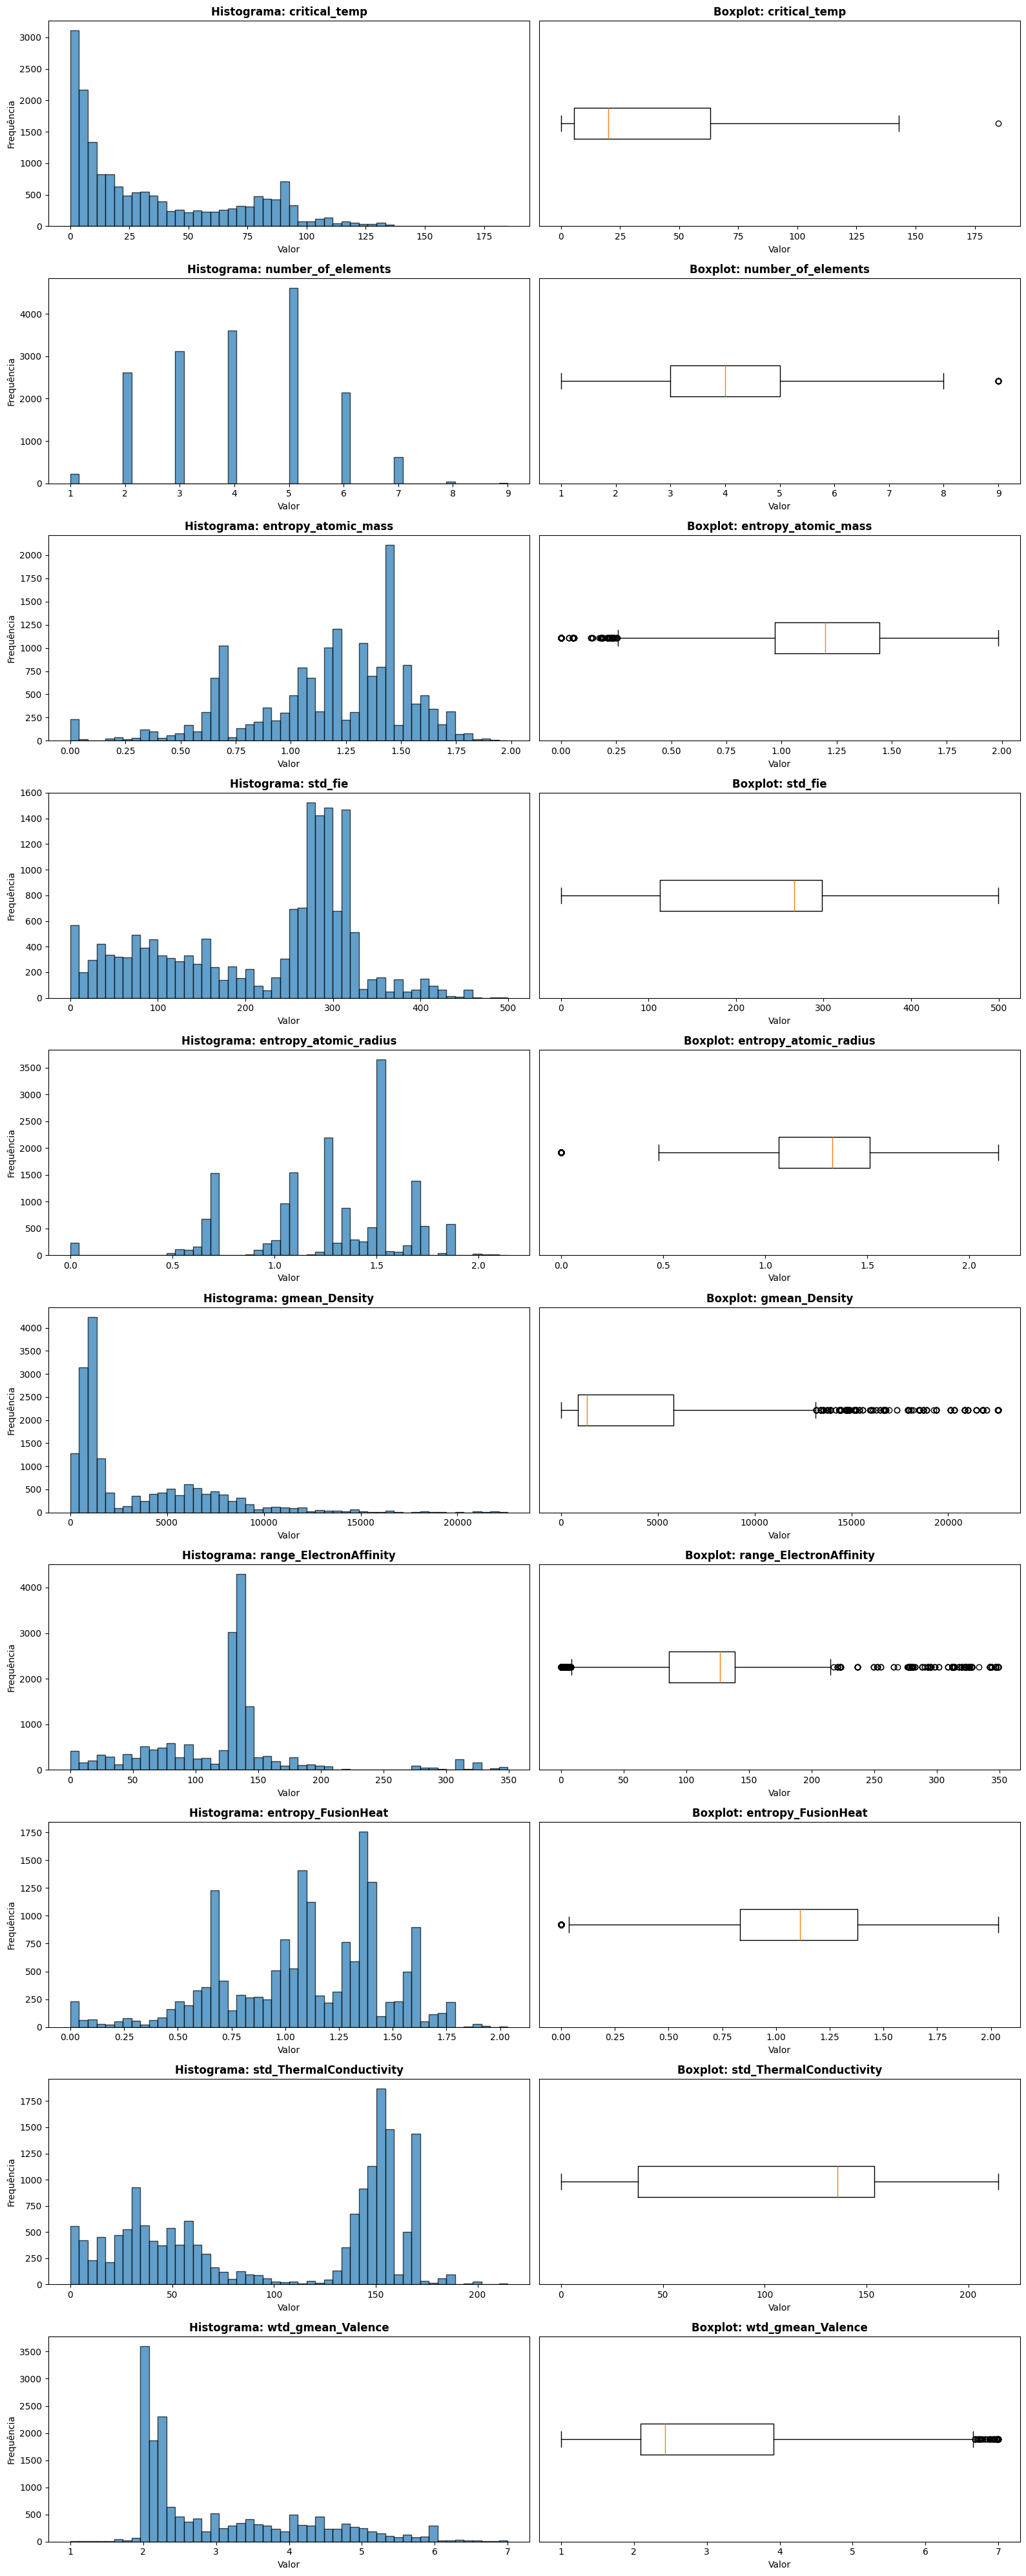

In [74]:
features = [
    'critical_temp',
    'number_of_elements',
    'entropy_atomic_mass',
    'std_fie',
    'entropy_atomic_radius',
    'gmean_Density',
    'range_ElectronAffinity',
    'entropy_FusionHeat',
    'std_ThermalConductivity',
    'wtd_gmean_Valence'
]

fig, axes = plt.subplots(10, 2, figsize=(16, 40))  # 10 features, 2 gráficos cada (hist + box)
axes = axes.flatten()

for i, feature in enumerate(features):
    dados_array = np.array(train_df[feature])

    # Histograma (esquerda)
    ax_hist = axes[2*i]
    ax_hist.hist(dados_array, bins=50, edgecolor='black', alpha=0.7)
    ax_hist.set_title(f'Histograma: {feature}', fontsize=12, fontweight='bold')
    ax_hist.set_xlabel('Valor')
    ax_hist.set_ylabel('Frequência')

    # Boxplot (direita)
    ax_box = axes[2*i+1]
    ax_box.boxplot(dados_array, vert=False)
    ax_box.set_title(f'Boxplot: {feature}', fontsize=12, fontweight='bold')
    ax_box.set_xlabel('Valor')
    ax_box.set_yticks([]) 

plt.tight_layout()
plt.show()